# Saliency Maps, Feature Visualisation and Adversarial Examples

Beyond simply training neural networks for an end goal, it's worth asking how exactly they might be achieving this. This line of research into interpreting the "black boxes" of neural networks has led to some particularly interesting results that should make us question if these models are truly learning the task, or are simply picking up on other biases in the dataset. All of the topics discussed here will be based around backpropagating gradients to the input space, although within these topics there are certainly more sophisticated and alternative methods available.

To begin with, we'll look at saliency maps, in which gradients are used to visualise what part of the input space a network is "attending" to. More specifically, it is usually based on the task loss, e.g., what part of this picture of a dog should be changed to make the network more confident that it is a dog. For feature visualisation, we'll instead change the input to maximally activate a hidden neuron - using the same gradient descent procedure as before, but instead optimising the input. Finally, we'll look at adversarial examples. Adversarial examples are inputs that are misinterpreted by machine learning models, but can appear perfectly normal to humans. These too can be created by optimising an input to fool the network.

## Data

We'll just use one image - a panda from the [ImageNet](http://image-net.org/) dataset. We'll also make note of some class indices - one for the panda, and one for trucks.

In [50]:
import os
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import autograd, nn, optim
from torchvision import models
from IPython.display import clear_output, display, Image
%matplotlib inline

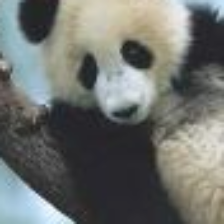

In [51]:
img = torch.tensor(np.transpose(plt.imread('assets/panda.png'), [2, 0, 1])).unsqueeze(0)
display(Image('assets/panda.png'))

panda_class, truck_class = 388, 867

## Model

We'll use a network that has already been trained on the Imagenet dataset, which we can download easily via `torchvision.models`. We'll use VGG-13, a fairly simple architecture with 13 layers. Since we want gradients on the input we can't use `torch.no_grad()`, but we want to avoid calculating gradients with respect to all of the parameters of the network. To avoid this, we'll loop over all of them, and set the property `requires_grad = False`.

All of the pretrained models available via `torchvision.models` use mean and standard deviation normalisation, so we'll make a small module to perform this for us while letting gradients go through it, and then add it to the bottom of the pretrained network using `nn.Sequential`. The `Normalise` module that we'll create will use `register_buffer` to keep track of variables that aren't meant for optimisation, which would otherwise be created by adding `nn.Parameter` attributes.

In [131]:
class Normalise(nn.Module):
    def __init__(self):
        super().__init__()
        self.register_buffer('mean_tensor', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std_dev_tensor', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, img):
        return (img - self.mean_tensor) / self.std_dev_tensor


model = models.vgg13(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.eval()
model = nn.Sequential(Normalise(), model)

## Saliency Map

To examine what the network is looking at with respect to a certain class, we'll backpropagate a vector of gradients from the logits (un-normalised probabilities) of the network where the target class has a gradient of 1 and the other classes have gradients of 0. We'll then display the normalised saliency map.

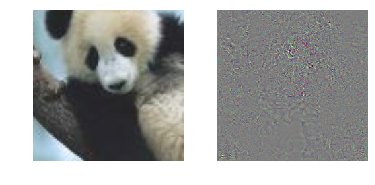

In [111]:
x = torch.tensor(img, requires_grad=True)
class_grads = torch.zeros(1, 1000)
class_grads[0, panda_class] = 1
white_bar = torch.ones(3, 224, 50)

plt.axis('off')

y = model(x)
autograd.backward(y, class_grads)
saliency = x.grad[0]
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    
display(plt.imshow(np.transpose(torch.cat([img[0], white_bar, saliency], 2).numpy(), [1, 2, 0])))
clear_output(wait=True)

Using "vanilla" gradients tends not to work so well for saliency maps. Consider what this means for interpretability techniques in general - they are formed out of a sequence of well-defined mathematical operations, but we have to consider what exactly they entail.

For the (relatively common) case of networks with ReLU nonlinearities, a technique called "guided backpropagation" has been introduced to improve the results. Guided backpropagation involves clamping the negative gradients to 0, preventing gradient flow through neurons that would decrease the activation of the neuron we are trying to maximise. There's been plenty of further research on saliency map methods which we won't go into here.

We'll use the ability of PyTorch to insert hooks into a network in order to modify the gradients in the backwards pass, and then remove them afterwards to make sure that we can continue to use the network as normal.

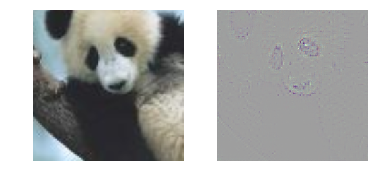

In [112]:
def guided_backprop(module, grad_in, grad_out):
    return (torch.clamp(grad_in[0], min=0), )


hook_handles = []
for module in model.modules():
    if isinstance(module, nn.ReLU):
        hook_handles.append(module.register_backward_hook(guided_backprop))

x = torch.tensor(img, requires_grad=True)

plt.axis('off')

y = model(x)
autograd.backward(y, class_grads)
saliency = x.grad[0]
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

[handle.remove() for handle in hook_handles]
    
display(plt.imshow(np.transpose(torch.cat([img[0], white_bar, saliency], 2).numpy(), [1, 2, 0])))
clear_output(wait=True)

## Feature Visualisation

In [120]:
cropped_model_1 = nn.Sequential(Normalise(), *[model[1].features[i] for i in range(6)])
cropped_model_2 = nn.Sequential(Normalise(), *[model[1].features[i] for i in range(13)])
cropped_model_3 = nn.Sequential(Normalise(), *[model[1].features[i] for i in range(23)])

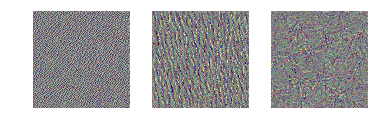

In [130]:
plt.axis('off')

x1 = torch.rand(1, 3, 224, 224, requires_grad=True)
x1.data.mul_(0.2).add_(0.4)
x2, x3 = torch.tensor(x1.detach(), requires_grad=True), torch.tensor(x1.detach(), requires_grad=True)
optimiser = optim.SGD([x1, x2, x3], lr=0.01)

for i in range(30):
    optimiser.zero_grad()
    y1, y2, y3 = cropped_model_1(x1), cropped_model_2(x2), cropped_model_3(x3)
    loss = -(y1[:, 0, :, :].mean() + y2[:, 0, :, :].mean() + y3[:, 0, :, :].mean())
    loss.backward()
    x1.grad /= (torch.sqrt(torch.mean(x1.grad.pow(2))) + 1e-5)
    x2.grad /= (torch.sqrt(torch.mean(x2.grad.pow(2))) + 1e-5)
    x3.grad /= (torch.sqrt(torch.mean(x3.grad.pow(2))) + 1e-5)
    optimiser.step()
    x1.data.clamp_(0, 1)
    x2.data.clamp_(0, 1)
    x3.data.clamp_(0, 1)

    visualisations = [x1[0].detach(), white_bar, x2[0].detach(), white_bar, x3[0].detach()]
    plt.imshow(np.transpose(torch.cat(visualisations, 2), [1, 2, 0]))
    display(plt.gcf())
    print(i)
    clear_output(wait=True)

## Deep Dream

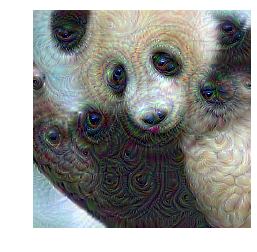

In [51]:
plt.axis('off')

x = torch.tensor(img, requires_grad=True)
for i in range(20):
    y = cropped_model(x)
    loss = -y[:, 0, :, :].mean()
    loss.backward()
    x.grad /= (torch.sqrt(torch.mean(x.grad.pow(2))) + 1e-5)
    x.data += 0.01 * x.grad
    x.data.clamp_(0, 1)
    x.grad.zero_()
    plt.imshow(np.transpose(x[0].detach(), [1, 2, 0]))
    display(plt.gcf())
    clear_output(wait=True)